http://mapfrappe.com/?show=51352

In [1]:
import time
import planarity
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import osmnx as ox
from scipy import stats
from shapely.geometry import Point, Polygon, LineString, MultiLineString

from planar import *

ox.config(use_cache=True, log_console=True)
%matplotlib inline

## Configure the script

In [2]:
df_places = pd.read_csv('data/places.csv')

distances = [805] #804.67 meters in each direction makes for 1 square mile, 500 meters is 1 sq km

network_types = ['drive', 'walk']

In [3]:
#df_places = df_places.loc[0:1]
df_places

,country,city,lat,lng
0,Argentina,Buenos Aires,-34.608657,-58.375547
1,Australia,Sydney,-33.863616,151.208977
2,Brazil,Sao Paulo,-23.549155,-46.633600
3,Canada,Toronto,43.649903,-79.380838
4,Canada,Vancouver,49.281651,-123.121363
5,Chile,Santiago,-33.439754,-70.654296
6,China,Beijing,39.908427,116.465505
7,China,Shanghai,31.236286,121.503787
8,China,Hong Kong,22.282321,114.156843
9,Denmark,Copenhagen,55.679443,12.578284


## Execute the script

In [4]:
# convert df to dict for execution
places = {}
for label, row in df_places.iterrows():
    key = '{}_{}'.format(row['country'], row['city'])
    value = (row['lat'], row['lng'])
    places[key] = value
    
places = df_places

In [5]:
results = []
for label, row in df_places.iterrows():
    
    coords = (row['lat'], row['lng'])
    point = Point(row['lng'], row['lat'])
    
    for network_type in network_types:
        
        for distance in distances:

            print(row['country'], row['city'], network_type, distance, end=' ')
            try:

                start_time = time.time()
                G = get_graph(coords, distance, network_type)

                # get a special buffered graph for planar analysis
                buffer = 500
                G_buff = get_graph(coords, distance + buffer, network_type)

                # get a bounding box to trim things square
                north, south, east, west = ox.bbox_from_point(coords, distance)
                bbox = Polygon([(west, north), (west, south), (east, south), (east, north)])

                # how many planar line intersections are there?
                planar_intersections = calculate_planar_intersections(G_buff, bbox)
                count_planar_intersections = len(planar_intersections)

                # how many nonplanar graph edge intersections are there?
                nonplanar_intersections = calculate_nonplanar_intersections(G, bbox)
                count_nonplanar_intersections = len(nonplanar_intersections)

                # how many cleaned, clustered intersections are there?
                cleaned_intersections = calculate_cleaned_intersections(nonplanar_intersections, G.graph['crs'])
                count_cleaned_intersections = len(cleaned_intersections)
                
                # how does planarity affect average edge length?
                mean_edge_length, mean_planar_segment_length, edge_length_ratio = calculate_edge_length_ratios(G, planar_intersections)

                if count_nonplanar_intersections > 0:
                    # planar line intersections overcounts nonplanar graph edge intersections by xx%
                    # ie, planar graph shows xx% more intersections than nonplanar graph with bridges/tunnels
                    planar_nonplanar_overcount = count_planar_intersections / count_nonplanar_intersections
                else:
                    planar_nonplanar_overcount = None #avoid divide by zero errors

                if count_cleaned_intersections > 0:
                    # edge intersections overcounts street intersections by xx%
                    nonplanar_cleaned_overcount = count_nonplanar_intersections / count_cleaned_intersections

                    # line intersections overcounts street intersections by xx%
                    planar_cleaned_overcount = count_planar_intersections / count_cleaned_intersections
                else:
                    planar_cleaned_overcount = None #avoid divide by zero errors
                    nonplanar_cleaned_overcount = None

                # is it a formally planar graph (ignoring spatial embedding)?
                warnings.filterwarnings('ignore')
                is_planar = planarity.is_planar(G)
                warnings.resetwarnings()
                
                runtime = round(time.time() - start_time, 2)
                print(runtime)
                
                # assemble the results
                result = {'country' : row['country'], 
                          'city' : row['city'],
                          'geometry' : point,
                          'distance' : distance,
                          'network_type' : network_type,
                          'nodes' : len(G.nodes()),
                          'count_planar_intersections' : count_planar_intersections,
                          'count_nonplanar_intersections' : count_nonplanar_intersections,
                          'count_cleaned_intersections' : count_cleaned_intersections,
                          'overcount_planar_nonplanar' : planar_nonplanar_overcount,
                          'overcount_nonplanar_cleaned' : nonplanar_cleaned_overcount,
                          'overcount_planar_cleaned' : planar_cleaned_overcount,
                          'mean_edge_length' : mean_edge_length,
                          'mean_planar_segment_length' : mean_planar_segment_length,
                          'edge_length_ratio' : edge_length_ratio,
                          'is_planar' : is_planar,
                          'runtime' : runtime}
                results.append(result)

            except Exception as e:
                print(e)

Argentina Buenos Aires drive 805 8.26
Argentina Buenos Aires walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f02ccae7041ed2992dd986d557f2973a.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/08e26ad7b03cbe0aa62de7d90f7d27e4.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


60.73
Australia Sydney drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/78c0ce84465289c5b79fea7cbe961c4c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/2975128ec65f4e97082a57bb1beff199.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


5.73
Australia Sydney walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/674505a008d6f9075abbc81728b89a5c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/7c01e55335ca366cde9224d192f2ec1b.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


79.42
Brazil Sao Paulo drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/eefd7351ab03c9bfd3cbf94f7cee87b0.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/d316bd76d8b21f7ce651d4012e5cd4ef.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


14.64
Brazil Sao Paulo walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/01e5045772bf66aee71e5df16e81acca.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/c9a125963510080870d14f4f55ac557c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


44.32
Canada Toronto drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/dfde2914697e09f33c0fc92cf1d766d8.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/6d96c5a59e90c65e2cb08f813ca8329e.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


8.26
Canada Toronto walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/60480897eb74b4bc307265d01e7453c2.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/b28f82f6194f7b9ffa83a0c17022adbc.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


1051.82
Canada Vancouver drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/9aa08aed64bb98092f8fdd18b94f8c38.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/3a0bcb9ba0c0fe249bc795114d656860.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


6.59
Canada Vancouver walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/16b182d608a814963d44914caf6403a9.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/1f6cb39bd2b2e7896e1ae6069180825a.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


66.02
Chile Santiago drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/cd3a3cfd9856a555065b8ac6e2b5747a.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/29af18f01a990cccb4efe0d262adabfb.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


8.67
Chile Santiago walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/47391779ff220c31d75020668f3c995b.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/55d6a5c2d1870a2c9774945efecf540b.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


29.38
China Beijing drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/b0736eec6d93698fc62be2cba6ef3417.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/674b4bbac9b1a81be5ed8fbe5cbd06d8.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


2.88
China Beijing walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/a597605d476b12fe5d35e4b9278ffa33.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/216d397dd9f1f805b3140734b1b46e75.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


7.13
China Shanghai drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/5360f116e17279894453f0986236e736.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/c19f3695b932b0b0e38b1258fe536309.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


5.49
China Shanghai walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/12e430b7cdc89781e565cfd5f5facb9f.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/ac61ccfde8ea44fc69cd193e66bfb7b1.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


17.55
China Hong Kong drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/4168405de91f28dd4eab168372bfa57f.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/0518cb95887bfed18abecaaf0cd4c4fe.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


13.91
China Hong Kong walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f42caab212a0061281f0243a0ca8c68a.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/1ddbeb0b56edf923549140af2e700eaf.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


132.19
Denmark Copenhagen drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/5503a8ae88b7a3261091b5fb59db3c94.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/a191e9a6d71c90949b3b26463ad91976.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


9.55
Denmark Copenhagen walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/a865031948871c9e74395b220fec4351.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e23e87522635b94a458b7442ddd78e19.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


92.47
Egypt Cairo drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/907ec55dc716dd6e2ce34e32ceb6de09.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/1ea742d2c1c1302f70b6fc70b3d5a9c2.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


13.08
Egypt Cairo walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/c5ada45be05d74845cd4916362260cb9.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/cee9aca3de21456a65f5dee7ac4dfab6.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


22.26
France Lyon drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/c39244440b0fbf8132fca650069896a4.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/83a4ac8032e53997bc929c0741c48864.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


22.21
France Lyon walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/a894c8436a13ff8e435df769574329d9.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/39f5a789ee7d0c2d8df9dd088eb5cb88.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


110.06
France Paris drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/458e25cf4f2b43914d2286c8fe19348e.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/50c01ca1a9a47de4ab66a7e616b07c0d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


15.6
France Paris walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/6193243c343338b0933eebd36520723c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e54ce6fceb786a6186e876faf6f3a16c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


98.52
Germany Berlin drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/0492d599989278126aaa6983f3a1d216.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e0cc4fbe2f8970a0aec8955f02a4bc61.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


6.43
Germany Berlin walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/ecbcc3091c2bc2761cdeddc18f82954b.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/cad884e84eb818b184e500fe0ce0ef50.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


199.3
India Delhi drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/47ba4608aeee20694d95766a973afaae.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/8d203bbc8f48ee6681b3d46c8275e552.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


1.84
India Delhi walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/b92cb49f96d38da3a1c18dd35a9ddf05.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e6b1c0f7ea80dd174518098251bb4943.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


12.86
Indonesia Jakarta drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/d536052f884ff9b25fc02d4c3910b23f.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f3062e44d40a9931d1d58871eb18f7d5.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


12.2
Indonesia Jakarta walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/4db4e63203b35a01d5b15428bd87c65d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/873ebdc3ef9f0cd3a0c46acc2f082e3a.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


25.84
Iran Tehran drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/ab973ffe7fbc95385137cb911500b285.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f70e05e8a80a4eb317b09973e0f0c2c0.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


44.85
Iran Tehran walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/7fdd51f879cb1955e00bd5fbc41b379a.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/25f1bc72f20cf2852db9aa9609e4e4ea.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


108.34
Italy Bologna drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/ba3aeb09e53359c227b9f1eb65545b37.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/4bfb9e7116c9afdb769799255ac6ab36.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


16.26
Italy Bologna walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f22ca9ed30c7bf8fac515889e517bb3d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/27a0574e6939b0ef9a36d343ac2d4bfe.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


127.57
Italy Florence drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/aef80e6842c89090a9099028ed04130d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/d71204b517302c7e4fa708335431ffc9.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


13.78
Italy Florence walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/9efce9e6de60a6a71797f6f82d38e7ea.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/bfa784d22160c4a2fb61c0d0e31d96d7.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


62.35
Italy Milan drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/fdada34da96653c1e44a466b6f6f9e7d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/954748f1889d45cc55abbb3524928e2b.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


13.63
Italy Milan walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/2d2a9d2f60cd3c0b416538346ce3ecd6.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/1065e1808c2cf80b5afa53045751e211.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


169.89
Japan Osaka drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/be9cc5e44cf20b36048fb43af5f61e87.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/354dd9adbbe966d0632cfa2d9a5196f7.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


41.73
Japan Osaka walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/3fd88ad4a98d91970d2dbfa26ed8f9e3.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/b99f0783eea1c01356d624c894bd6446.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


217.83
Japan Tokyo drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/6bc54ef9b961a4efb5fe53f80f7e85da.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f787aa6f9269404fd6de887d1f925651.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


65.79
Japan Tokyo walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/4b24e5b39e457d0120f5f993b8391411.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/605be3bb8ae56c326b8f09fa5a18bd2d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


160.34
Kenya Nairobi drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/b1e26a2e4e2aa464b6098813715be02a.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/eb0032b3a7c80a6b038f682e3a851083.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


10.88
Kenya Nairobi walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/62510a0574ae555d6c9f1294bde0423c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/70c19651becb83f93c8e1a80aa1a8e92.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


19.9
Mexico Mexico City drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/94b8f445d255106b3d0c1d33aea17a43.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/0c717cf066e04925221c2b5c6e969eb8.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


21.56
Mexico Mexico City walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/a9b63a8c381baab893fca0fa40921ec5.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/4815cac8d4b98902bef42d10a463c47d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


32.49
Nigeria Lagos drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/4abef9f1c426b66725ee7087a61f80d4.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/2f7d24df10667374b73c612cac29cbfd.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


15.81
Nigeria Lagos walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/5ad535cf8da544154ea02e87e588303e.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/552cb0e9fa039646abab4921360f0e32.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


14.48
Peru Lima drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/7405f6a547c9f490c2de8d8a272e43c9.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e56d1ec4e06511ebbd0b6c86239623a1.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


16.16
Peru Lima walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f0553aa0497d517bd66ecb2db203feff.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/1310b22a920b2d85c50ade433a02e155.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


45.72
Philippines Manila drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/10469c105b9116f9222f7ddcc25977fa.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/b8663f40ae7af3b98bbdace7aecbfe69.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


13.33
Philippines Manila walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e1af2e6247f38e4ffbe578c3c1cf3a2c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/096e8a2a3330c5454a8d160c5c37b676.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


43.39
Russia Moscow drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/08c0eb6fada7ec634c63c70be555577f.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/248378b4a9c38df45217bf1211927730.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


2.12
Russia Moscow walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/723787ccc87880ea8928209065584e45.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/1deb2186d08e5cbe22382e8d1e7a0850.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


67.99
Singapore Singapore drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/4f623dd1c096d6eac6209e2d3bd13adb.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/b5277db6f880929e731ceb169279c206.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


4.79
Singapore Singapore walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/fb24482574761c26a9bfbd67f1227d61.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/59334659fd4ebe472c43458935b8fb58.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


107.53
Somalia Mogadishu drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/45528b12bcbcb3a2b2b02510ade16fb9.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/0a7091cd15dd1ef45a51674d0540d973.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


245.42
Somalia Mogadishu walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/734ab1fb8f040e192080978b02d52e94.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f9f642097a4c277b57ea32f89dd31178.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


247.02
South Africa Johannesburg drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/dc02723da4853ae293b7aa9f11c9db77.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/4f2e531e5df7f2e717eb55536d6032c8.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


14.16
South Africa Johannesburg walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/984cd26a27f8a3c05f981cf71a41cec0.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/d9069abbe8f5c6f7ac674380c0480a38.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


14.81
Spain Barcelona drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/84814bc4bc5b1721799960c6dbac6cbb.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/94fdc3b82721f9d3674f83129a9e1d79.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


7.77
Spain Barcelona walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/ac80b3fa9af7bd1d5be517f63b930e2e.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/2eb9518412ba4d32aebe471c936fbb82.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


135.96
Switzerland Geneva drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/61a3330311369b849c459ca9b9bab0a6.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/3d70205f90461271207572083961c9cc.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


34.9
Switzerland Geneva walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/422a1aca32e8fc43f6df48687d2501e8.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/203cb01d53132b1adaf06a75b70f01c7.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


445.51
Thailand Bangkok drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/90f4be8001855854f26509066c26232c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/2d3430a46e13316982736806e9410325.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


22.56
Thailand Bangkok walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/cad3dbf6dfabeb58f6bd333fb74d5981.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/160bc9fc8a7e046f19569147a3c61d9d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


44.95
Turkey Istanbul drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e2a408cc5c8bbd803f3bd633fe210e82.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f5b2f4262f4ad61f2caf3faafa2ada84.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


40.22
Turkey Istanbul walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/06f660b8091992b63c0e7ab63579e46d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/ad460b519b24cf6123553eb4dd20d569.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


131.42
UAE Dubai drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/3b5195f9f9e5d0dd8180e36d6799519c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/c7df283bf93e6e8d48ba490263e615da.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


6.0
UAE Dubai walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/82acfb15663b8ff48da31234e4964d2d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/a18479b76859c0acfe5018e75cd3ce0d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


15.25
UK Edinburgh drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/5a14228d4ca7cea4e7db4823229d683e.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/00d3b655d7a04a22811136280362beb7.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


9.8
UK Edinburgh walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/a8c740c54e6b835259ddfd5b552df47a.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/49f0c16734c4444bcd078b2f02163410.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


270.41
UK London drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/510bed7bfcd76fa65ea573cc426518f8.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/9f9eaddc4c73378d353473f265a1b070.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


23.49
UK London walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/97b9236cc986b76fa417980956bd31a1.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/bf9329225e43e615bede5023f5e1e6c3.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


460.53
USA Atlanta drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/29719a18a93d351eb2333f637fec09a7.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/99b2a37cd9098dbad58cf3633be39fae.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


7.77
USA Atlanta walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/58f43c2ce4861bcb0698b1231ffd9c14.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/d5e0d67b1818420bd22c7ab8a2b94eb1.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


32.99
USA Chicago drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/6f2fca8272f4163f07b7bf3966460029.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/aa40873e89ffd7ef769122914fac9c44.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


10.87
USA Chicago walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/fa6e6e85e494ddfb0dc151b44da3da35.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/9f3665003cb202c9e29c3525bb8eeb07.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


192.03
USA Cincinnati drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/84281e91664ada8c69b2f6a413f09ce8.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e95c4278df9bb9c46372400d0b52366b.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


10.78
USA Cincinnati walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/aa2792b5b587b04f289de0b2bc24c906.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/9575aed51f4b3f15bd91f5d4276ce78b.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


76.68
USA Dallas drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/17bfdef6839e8d2a8d0164bb2474f431.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/5a963c6268d2c73b0300ea1e705eba60.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


15.35
USA Dallas walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/860adf192d1ab0f1ab62e667e1afbdd9.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f347663bd3426418c7aa360f0c78c36c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


48.45
USA Los Angeles drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/ea493d53d78ce83cc2429f97a923f092.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/616c1fa6b96c71b9a304a41105d03aa4.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


7.7
USA Los Angeles walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/db18b07b5fc72f967c5f5efa5375f6b8.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/a0f23f021b124472844143dbd05f2750.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


53.09
USA Miami drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e7dfa7fe34f21b85ededdcfde9ab803b.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/bc67008006354621cf30b99a1b1af238.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


8.37
USA Miami walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/1fee45d6cc82c7e9154ec02d8e695212.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/655d1ebeccc3e2605e94a26f24e7d51c.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


25.75
USA New York drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/3a2b0c87a7dd67874cc25f10228ce6b3.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/161278c7e9a649b1b45f936bbf441db9.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


16.53
USA New York walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/bed41ed659219923d37ffcd3bc0c38d4.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/d97c4d745dca686c55e313bdcc3f37ba.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


109.85
USA Phoenix drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/63f56b72c0df754f23272e51c050ecd6.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/cef3caa74879b4f71ddd97bd483f692d.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


6.75
USA Phoenix walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/86e5234512eb5251a68675fda5a0292b.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/9cebfcb3069e7bb097a045e3311f7c01.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


112.26
USA San Francisco drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/58bc8f0ca5ce06e95ac50ce7e45ae4d9.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/cfb4262fce0c9770fe3384cfc202e641.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


8.34
USA San Francisco walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/3cf5acd173202c1c6d777a8c8d940805.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/30fa80c6009bfd9b70e5e6c4d96c0d9e.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


92.44
USA Seattle drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/9b04c19309a2b835ef922ea085d35c32.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/76b92190f40a9969db7aef9281057581.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


15.94
USA Seattle walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/b750f9ee67caff7595dc00d666b87c89.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/5983e6d7af5fe24b8e690d1d2bea0841.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


333.85
USA Washington DC drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/f1a4d1f17c97440f5c6cf665f2a813bf.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/c9761ff2fc6c4fd1702eb09df3e5b923.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


17.27
USA Washington DC walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/a143fc62d76b45971d77f0680fb26979.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/91f6e6dd1df0670f7cb5df7788af535a.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


235.8
Venezuela Caracas drive 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/760316881960c213b9b2ba29ec3a14bd.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/e8b558e7b73dd649452c94099819375f.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


7.83
Venezuela Caracas walk 805 

g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/b61e7e55a4c1a2eab70fc54918034254.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))
g:\geoff\dropbox\documents\school\phd\projects\code\osmnx-repos\osmnx\osmnx\core.py:112: ResourceWarning: unclosed file <_io.TextIOWrapper name='cache/47cf0803991bf286fb64c6bbbf25f1d8.json' mode='r' encoding='utf-8'>
  response_json = json.load(io.open(cache_path_filename, encoding='utf-8'))


10.92


In [6]:
gdf = gpd.GeoDataFrame(results, geometry='geometry').round(3)
gdf.crs = {'init': 'epsg:4326'}
print('finished in {:.2f} minutes'.format(gdf['runtime'].sum() / 60))

finished in 121.53 minutes


In [7]:
# display the results
gdf

,city,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,country,distance,edge_length_ratio,geometry,is_planar,mean_edge_length,mean_planar_segment_length,network_type,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,runtime
0,Buenos Aires,211,222,222,Argentina,805,1.000,POINT (-58.375547 -34.608657),True,111.152,111.151,drive,272,1.052,1.052,1.000,8.26
1,Buenos Aires,291,652,689,Argentina,805,0.947,POINT (-58.375547 -34.608657),False,55.278,52.375,walk,871,2.241,2.368,1.057,60.73
2,Sydney,151,177,239,Australia,805,0.749,POINT (151.208977 -33.863616),False,150.771,112.902,drive,223,1.172,1.583,1.350,5.73
3,Sydney,499,808,889,Australia,805,0.901,POINT (151.208977 -33.863616),False,53.459,48.141,walk,1018,1.619,1.782,1.100,79.42
4,Sao Paulo,288,330,417,Brazil,805,0.790,POINT (-46.6336 -23.549155),False,111.740,88.282,drive,415,1.146,1.448,1.264,14.64
5,Sao Paulo,418,587,689,Brazil,805,0.831,POINT (-46.6336 -23.549155),False,76.628,63.694,walk,721,1.404,1.648,1.174,44.32
6,Toronto,203,214,230,Canada,805,0.958,POINT (-79.380838 43.649903),True,115.019,110.150,drive,271,1.054,1.133,1.075,8.26
7,Toronto,595,2834,3302,Canada,805,0.848,POINT (-79.380838 43.649903),False,33.584,28.476,walk,3356,4.763,5.550,1.165,1051.82
8,Vancouver,171,182,196,Canada,805,0.948,POINT (-123.121363 49.281651),False,133.992,127.027,drive,231,1.064,1.146,1.077,6.59
9,Vancouver,450,692,745,Canada,805,0.926,POINT (-123.121363 49.281651),False,67.541,62.550,walk,870,1.538,1.656,1.077,66.02


In [8]:
gdf[['city', 'overcount_planar_nonplanar']].sort_values(by='overcount_planar_nonplanar').head(10)

,city,overcount_planar_nonplanar
0,Buenos Aires,1.000
62,Barcelona,1.000
59,Mogadishu,1.000
58,Mogadishu,1.000
38,Milan,1.000
36,Florence,1.000
34,Bologna,1.000
28,Delhi,1.000
99,Caracas,1.000
61,Johannesburg,1.003


## Visualize results

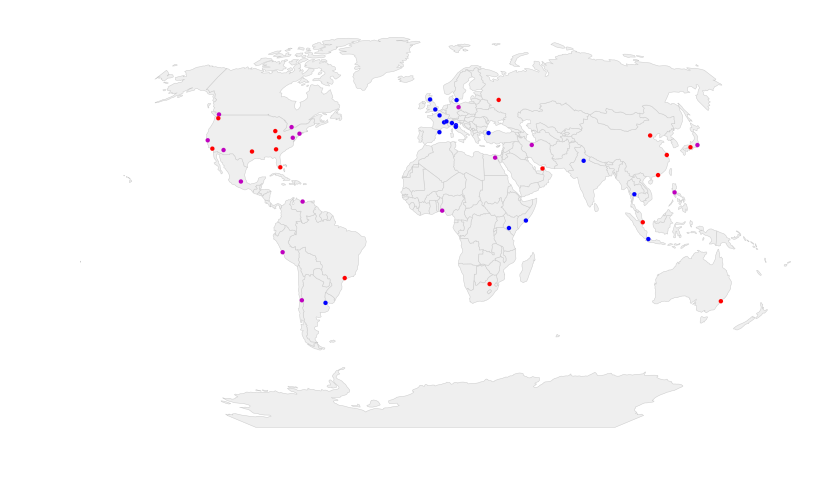

In [9]:
def get_color(value, breaks):
    
    if value <= breaks[0]:
        return 'b'
    elif value <= breaks[1]:
        return 'm'
    else:
        return 'r'
    
drive = gdf[gdf['network_type']=='drive']
breaks = [drive['overcount_planar_nonplanar'].quantile(q=x) for x in (0.33, 0.67)]
colors = drive['overcount_planar_nonplanar'].apply(get_color, breaks=breaks)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
crs_proj = '+proj=kav7'
world_proj = world.to_crs(crs_proj)
xmin, ymin, xmax, ymax = world_proj.unary_union.bounds
aspect_ratio = (xmax - xmin) / (ymax - ymin)
points_proj = drive.to_crs(crs_proj)

width = 14
fig, ax = plt.subplots(figsize=(width, width/aspect_ratio), facecolor='w')
ax = world_proj.plot(ax=ax, facecolor='#efefef', edgecolor='#cccccc', linewidth=0.5)
ax = points_proj.plot(ax=ax, marker='o', markersize=20, c=colors, edgecolor='#efefef', linewidth=0.1)
ax.axis('off')
fig.savefig('data/world_map.png', dpi=300)
plt.show()

<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence \g
<input>:27: DeprecationWarning: invalid escape sequence 

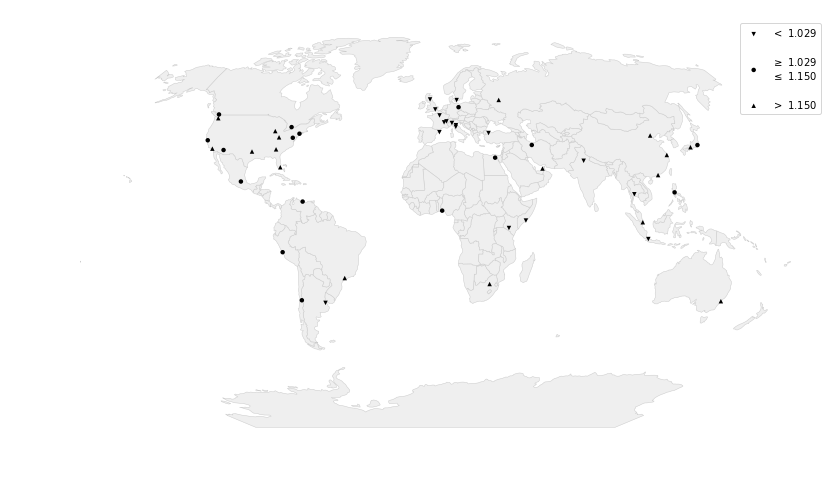

In [10]:
def get_marker(value, breaks):
    
    if value <= breaks[0]:
        return 1
    elif value <= breaks[1]:
        return 2
    else:
        return 3
    
drive = gdf[gdf['network_type']=='drive'].copy()
breaks = [drive['overcount_planar_nonplanar'].quantile(q=x) for x in (0.33, 0.67)]
drive['group'] = drive['overcount_planar_nonplanar'].apply(get_marker, breaks=breaks)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
crs_proj = '+proj=kav7'
world_proj = world.to_crs(crs_proj)
xmin, ymin, xmax, ymax = world_proj.unary_union.bounds
aspect_ratio = (xmax - xmin) / (ymax - ymin)
points_proj = drive.to_crs(crs_proj)

width = 14
fig, ax = plt.subplots(figsize=(width, width/aspect_ratio), facecolor='w')
ax = world_proj.plot(ax=ax, facecolor='#efefef', edgecolor='#cccccc', linewidth=0.5)

groups = []
points_proj[points_proj['group']==1].plot(ax=ax, marker='v', markersize=20, c='k', edgecolor='none', label='$<$ {:.3f}'.format(breaks[0]))
points_proj[points_proj['group']==2].plot(ax=ax, marker='o', markersize=20, c='k', edgecolor='none', label='\n$\geq$ {:.3f}\n$\leq$ {:.3f}\n'.format(breaks[0], breaks[1]))
points_proj[points_proj['group']==3].plot(ax=ax, marker='^', markersize=20, c='k', edgecolor='none', label='$>$ {:.3f}'.format(breaks[1]))
    
plt.legend()

ax.axis('off')
fig.savefig('data/world_map_bw.png', dpi=300)
plt.show()

r^2 = 0.968


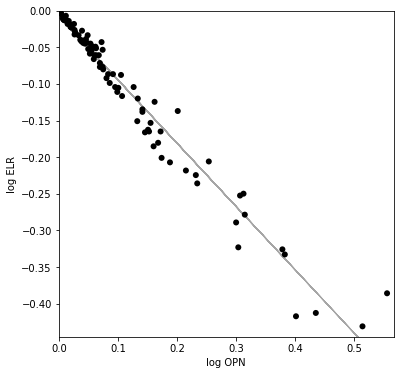

In [11]:
x = np.log(gdf['overcount_planar_nonplanar'].copy())
y = np.log(gdf['edge_length_ratio'].copy())
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print('r^2 = {:.3f}'.format(r_value ** 2))

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=x, y=y, c='k', edgecolor='none', marker='o')

# set x and y limits
x_min = x.min() * 0.98
x_max = x.max() * 1.02
y_min = y.min() * 0.98
y_max = y.max() * 1.02
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# create a line of best fit
x_line = x.copy()
x_line.loc[len(x_line)] = x_min
x_line.loc[len(x_line)] = x_max
Y_est = x_line * slope + intercept
ax.plot(x_line, Y_est, c='k', alpha=0.35, linewidth=1, zorder=-1)

ax.set_xlabel('log OPN')
ax.set_ylabel('log ELR')
fig.savefig('data/regression.png', dpi=300)
plt.show()

drive r^2 = 0.980
walk r^2 = 0.994


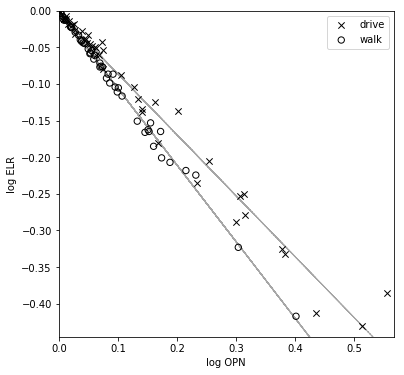

In [12]:
walk = gdf[gdf['network_type']=='walk']
drive = gdf[gdf['network_type']=='drive']

def transform(data):
    return np.log(data)

x = transform(gdf['overcount_planar_nonplanar'].copy())
y = transform(gdf['edge_length_ratio'].copy())
drive_x = transform(drive['overcount_planar_nonplanar'].copy())
drive_y = transform(drive['edge_length_ratio'].copy())
walk_x = transform(walk['overcount_planar_nonplanar'].copy())
walk_y = transform(walk['edge_length_ratio'].copy())

drive_slope, drive_intercept, drive_r_value, drive_p_value, drive_std_err = stats.linregress(drive_x, drive_y)
print('drive r^2 = {:.3f}'.format(drive_r_value ** 2))

walk_slope, walk_intercept, walk_r_value, walk_p_value, walk_std_err = stats.linregress(walk_x, walk_y)
print('walk r^2 = {:.3f}'.format(walk_r_value ** 2))

fig, ax = plt.subplots(figsize=(6,6))
drive_scatter = ax.scatter(x=drive_x, y=drive_y, c='k', edgecolor='none', s=40, linewidth=1, marker='x')
walk_scatter = ax.scatter(x=walk_x, y=walk_y, c='none', edgecolor='k', s=40, linewidth=1, marker='o')

# set x and y limits
x_min = x.min() * 0.98
x_max = x.max() * 1.02
y_min = y.min() * 0.98
y_max = y.max() * 1.02
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# create a line of best fit
x_line = x.copy()
x_line.loc[len(x_line)] = x_min
x_line.loc[len(x_line)] = x_max

drive_Y_est = x_line * drive_slope + drive_intercept
drive_line = ax.plot(x_line, drive_Y_est, c='k', alpha=0.35, linestyle=':', linewidth=1, zorder=-1)

walk_Y_est = x_line * walk_slope + walk_intercept
walk_line = ax.plot(x_line, walk_Y_est, c='k', alpha=0.35, linestyle='--', linewidth=1, zorder=-1)

ax.set_xlabel('log OPN')
ax.set_ylabel('log ELR')
plt.legend([drive_scatter, walk_scatter], ['drive', 'walk'])

fig.savefig('data/regression_split.png', dpi=300)
plt.show()

## Visualize one result

(10.494903, -66.850865)


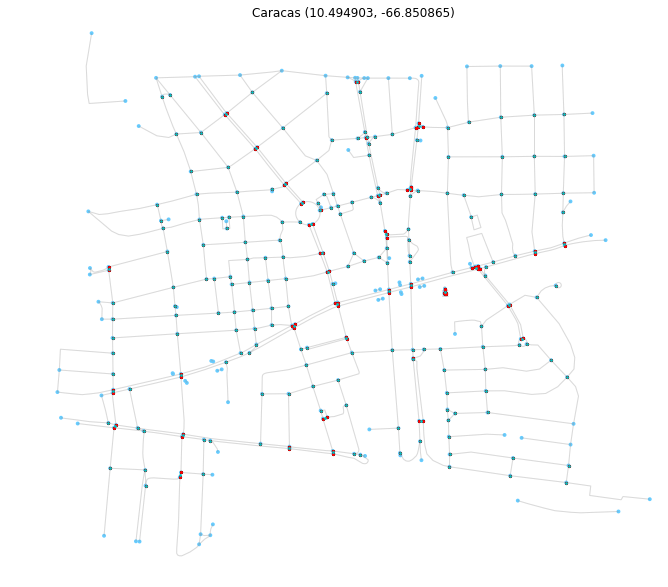

In [13]:
fig, ax = ox.plot_graph(G, fig_height=10, edge_alpha=0.2, node_alpha=None, close=True, show=False)

# show the true intersections in black
xs = nonplanar_intersections.map(lambda pt: pt.x)
ys = nonplanar_intersections.map(lambda pt: pt.y)
ax.scatter(xs, ys, c='k', s=5, zorder=2)

# plot the line split points in red to show false intersections
xs = planar_intersections.map(lambda pt: pt.x)
ys = planar_intersections.map(lambda pt: pt.y)
ax.scatter(xs, ys, c='r', s=4, zorder=3)

# plot consolidated intersections in cyan
xs = cleaned_intersections.map(lambda pt: pt.x)
ys = cleaned_intersections.map(lambda pt: pt.y)
ax.scatter(xs, ys, c='c', s=3, zorder=4)

print(coords)
ax.set_title('{} {}'.format(row['city'], coords))
fig.canvas.draw()
fig

## Save results to disk

In [14]:
ox.save_graph_shapefile(G, filename='graph', folder='data')

In [15]:
planar_intersections.to_file('data/graph/planar')
nonplanar_intersections.to_file('data/graph/nonplanar')
cleaned_intersections.to_file('data/graph/cleaned')

In [16]:
north, south, east, west = ox.bbox_from_point(coords, distance)
polygon = Polygon([(west, north), (west, south), (east, south), (east, north)])
gpd.GeoSeries([polygon]).to_file('data/graph/bbox')

In [17]:
gdf.to_csv('data/results.csv', index=True, encoding='utf-8')

In [18]:
gdf2 = gdf.set_index(['country', 'city', 'distance', 'network_type'])
gdf2.iloc[gdf2.index.get_level_values('network_type') == 'drive'].to_csv('data/results_drive.csv')
gdf2.iloc[gdf2.index.get_level_values('network_type') == 'walk'].to_csv('data/results_walk.csv')

## Make latex table

In [19]:
cols = ['country', 'city', 'network_type', 'is_planar', 'overcount_planar_nonplanar', 
        'overcount_nonplanar_cleaned', 'edge_length_ratio']
table = gdf[cols].reindex(cols, axis=1).set_index(['country', 'city', 'network_type']).unstack(level=2)
table = table.swaplevel(i=0, j=1, axis=1)
table.columns = ['_'.join(col).strip() for col in table.columns]
table = table.rename(columns={'drive_edge_length_ratio' : 'd_ELR', 'drive_is_planar' : 'd_planar',
                      'drive_overcount_nonplanar_cleaned' : 'd_ONC', 'drive_overcount_planar_nonplanar' : 'd_OPN',
                      'walk_edge_length_ratio' : 'w_ELR', 'walk_is_planar' : 'w_planar',
                      'walk_overcount_nonplanar_cleaned' : 'w_ONC', 'walk_overcount_planar_nonplanar' : 'w_OPN'})
table = table.reindex(['d_planar', 'd_OPN', 'd_ONC', 'd_ELR', 'w_planar', 'w_OPN', 'w_ONC', 'w_ELR'], axis=1)
table['d_planar'] = table['d_planar'].map(lambda x: 'Yes' if x else 'No')
table['w_planar'] = table['w_planar'].map(lambda x: 'Yes' if x else 'No')
table

d_planar  d_OPN  d_ONC  d_ELR w_planar  w_OPN  \
country      city                                                          
Argentina    Buenos Aires       Yes  1.000  1.052  1.000       No  1.057   
Australia    Sydney              No  1.350  1.172  0.749       No  1.100   
Brazil       Sao Paulo           No  1.264  1.146  0.790       No  1.174   
Canada       Toronto            Yes  1.075  1.054  0.958       No  1.165   
             Vancouver           No  1.077  1.064  0.948       No  1.077   
Chile        Santiago            No  1.143  1.074  0.887       No  1.028   
China        Beijing             No  1.223  1.754  0.872       No  1.188   
             Hong Kong           No  1.183  1.317  0.835       No  1.190   
             Shanghai            No  1.466  1.615  0.717       No  1.494   
Denmark      Copenhagen         Yes  1.008  1.175  0.988       No  1.009   
Egypt        Cairo               No  1.111  1.110  0.916       No  1.090   
France       Lyon                No  1.009  1.225  0.989       No  1.042   
             Paris               No  1.012  1.163  0.993       No  1.087   
Germany      Berlin              No  1.065  1.267  0.950       No  1.061   
India        Delhi              Yes  1.000  1.462  1.000      Yes  1.007   
Indonesia    Jakarta            Yes  1.017  1.218  0.986       No  1.040   
Iran         Tehran              No  1.040  1.350  0.973       No  1.045   
Italy        Bologna            Yes  1.000  1.218  1.000      Yes  1.004   
             Florence           Yes  1.000  1.212  1.000       No  1.021   
             Milan              Yes  1.000  1.259  1.000       No  1.142   
Japan        Osaka               No  1.152  1.215  0.871       No  1.051   
             Tokyo               No  1.078  1.333  0.923       No  1.084   
Kenya        Nairobi             No  1.027  1.372  0.974       No  1.054   
Mexico       Mexico City         No  1.064  1.249  0.952       No  1.096   
Nigeria      Lagos               No  1.050  1.085  0.967       No  1.012   
Peru         Lima                No  1.065  1.344  0.941       No  1.072   
Philippines  Manila              No  1.057  1.192  0.953       No  1.104   
Russia       Moscow              No  1.743  1.186  0.680       No  1.168   
Singapore    Singapore           No  1.152  1.375  0.874       No  1.113   
Somalia      Mogadishu          Yes  1.000  1.044  1.000      Yes  1.000   
South Africa Johannesburg        No  1.176  1.057  0.883       No  1.003   
Spain        Barcelona          Yes  1.000  1.265  1.000       No  1.106   
Switzerland  Geneva              No  1.015  1.249  0.982       No  1.207   
Thailand     Bangkok             No  1.012  1.258  0.988       No  1.007   
Turkey       Istanbul            No  1.026  1.222  0.982       No  1.020   
UAE          Dubai               No  1.460  1.303  0.722       No  1.163   
UK           Edinburgh           No  1.027  1.333  0.968       No  1.012   
             London              No  1.022  1.276  0.981       No  1.157   
USA          Atlanta             No  1.359  1.042  0.777       No  1.355   
             Chicago             No  1.289  1.414  0.814       No  1.240   
             Cincinnati          No  1.370  1.141  0.757       No  1.074   
             Dallas              No  1.672  1.311  0.650      Yes  1.039   
             Los Angeles         No  1.717  1.111  0.635       No  1.261   
             Miami               No  1.545  1.189  0.662       No  1.037   
             New York            No  1.135  1.144  0.901       No  1.062   
             Phoenix             No  1.047  1.206  0.962       No  1.022   
             San Francisco       No  1.070  1.093  0.941       No  1.055   
             Seattle             No  1.367  1.047  0.779       No  1.072   
             Washington DC       No  1.055  1.351  0.956       No  1.034   
Venezuela    Caracas             No  1.049  1.230  0.957      Yes  1.000   

                            w_ONC  w_ELR  
country      city              

In [20]:
print(table.to_latex())

\begin{tabular}{lllrrrlrrr}
\toprule
          &         & d\_planar &  d\_OPN &  d\_ONC &  d\_ELR & w\_planar &  w\_OPN &  w\_ONC &  w\_ELR \\
country & city &          &        &        &        &          &        &        &        \\
\midrule
Argentina & Buenos Aires &      Yes &  1.000 &  1.052 &  1.000 &       No &  1.057 &  2.241 &  0.947 \\
Australia & Sydney &       No &  1.350 &  1.172 &  0.749 &       No &  1.100 &  1.619 &  0.901 \\
Brazil & Sao Paulo &       No &  1.264 &  1.146 &  0.790 &       No &  1.174 &  1.404 &  0.831 \\
Canada & Toronto &      Yes &  1.075 &  1.054 &  0.958 &       No &  1.165 &  4.763 &  0.848 \\
          & Vancouver &       No &  1.077 &  1.064 &  0.948 &       No &  1.077 &  1.538 &  0.926 \\
Chile & Santiago &       No &  1.143 &  1.074 &  0.887 &       No &  1.028 &  1.261 &  0.971 \\
China & Beijing &       No &  1.223 &  1.754 &  0.872 &       No &  1.188 &  1.743 &  0.848 \\
          & Hong Kong &       No &  1.183 &  1.317 &  0.835 &    